# Instructions 

1. Install tensorflow - "pip install tensorflow". Ensure the latest version of tensorflow is installed.   
- Install Keras - "pip install keras". Ensure keras v2.1.3 is installed. 
- Install scipy, numpy and scikit-learn libraries via pip. 


## load the files 

In [1]:
# necessary libraries 
import pickle
import numpy as np
% matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import itertools

In [2]:
# file load helpers 
_totalBatch = 5
_IMAGE_NORMALISED = False

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def loadTrainigBatch(filepath):
    rawRGBFeatures = None
    trainingLabels = None
    
    for i in range(_totalBatch):
        # load all 5 batches and join the raw RGB data and indexes by row (vstack/hstack)? 
        #print(i+1)
        #print(batch1.keys())
        #print(labelMeta.keys())
        batch = unpickle(filepath + str(i + 1)) # load batch
        if i == 0: 
            rawRGBFeatures = batch.get(b"data")
            trainingLabels = batch.get(b"labels")
        else:
            rawRGBFeatures = np.vstack((rawRGBFeatures,batch.get(b"data")))
            trainingLabels = np.hstack((trainingLabels,batch.get(b"labels")))
    
    return rawRGBFeatures, trainingLabels

def loadHeldOutBatch(filepath):
    rawRGBFeatures = None
    labels = None
    
    batch = unpickle(filepath) # load batch
    rawRGBFeatures = batch.get(b"data")
    labels = np.asarray(batch.get(b'labels'))
    
    return rawRGBFeatures, labels

# image display helpers 
def printRandom10Images(rawData, labels, seed):    
    allImages = np.rot90(np.reshape(rawData, (rawData.shape[0],32,32,3), order='F'), axes=(2,1))
    print("raw image dimensions:", allImages.shape)
    # plot the first 10 random images to verify the conversion
    fig = plt.figure(figsize=(6,3))
    counter = 0
    random.seed(seed)
    for i in random.sample(range(1, rawData.shape[0]), 10):
        ax = fig.add_subplot(2, 5, 1 + counter, xticks=[], yticks=[])
        im = allImages[i,:,:,:] 
        ax.set_title(text_labels[labels[i]])
        plt.imshow(im)
        counter += 1
    plt.show()
    


In [3]:
# file loads - raw data + numerical labels + text labels

rawRGBFeatures, trainingLabels = loadTrainigBatch("data/cifar-10-batches-py/data_batch_")
labelMeta = unpickle("data/cifar-10-batches-py/batches.meta") # load the label metadata
text_labels = [x.decode("utf-8") for x in labelMeta.get(b"label_names")] # to convert from byte literal to string

print(rawRGBFeatures.shape)
print(trainingLabels.shape)

# extraction unique labels 
labels = np.unique(trainingLabels)
print(labels)
print(text_labels)

(50000, 3072)
(50000,)
[0 1 2 3 4 5 6 7 8 9]
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
# load the held out dataset 
holdOutRawFeatures, holdOutLabels = loadHeldOutBatch("data/cifar-10-batches-py/test_batch")
print(holdOutRawFeatures.shape)
print(holdOutLabels.shape)

(10000, 3072)
(10000,)


raw image dimensions: (50000, 32, 32, 3)


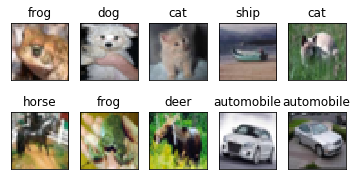

In [5]:
# print random 10 images
printRandom10Images(rawRGBFeatures,trainingLabels, seed=5)

## normalise the images (RGB) 

At times, you want to get rid of distortions caused by lights and shadows in an image. Normalizing the RGB values of an image can at times be a simple and effective way of achieving this.

When normalizing the RGB values of an image, you divide each pixel's value by the sum of the pixel's value over all channels. So if you have a pixel with intensitied R, G, and B in the respective channels... its normalized values will be R/S, G/S and B/S (where, S=R+G+B).

normalising
Images from the training set
raw image dimensions: (50000, 32, 32, 3)


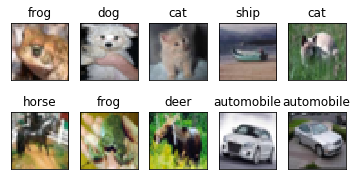

Images from the held out set
raw image dimensions: (10000, 32, 32, 3)


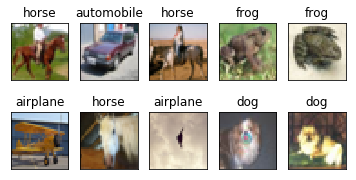

In [6]:
# normalise 
rawRGBFeatures = rawRGBFeatures.astype("float32") # convert the dataset to float32
holdOutRawFeatures = holdOutRawFeatures.astype("float32") 
if not _IMAGE_NORMALISED: 
    print("normalising")
    rawRGBFeatures = rawRGBFeatures/255 # normalise by dividing by 255
    holdOutRawFeatures = holdOutRawFeatures/255
    _IMAGE_NORMALISED = True
# now plot again to see verify the image quality 
print("Images from the training set")
printRandom10Images(rawRGBFeatures, trainingLabels, seed=5)
print("Images from the held out set")
printRandom10Images(holdOutRawFeatures, holdOutLabels, seed=5)


In [7]:
# split the data into train and test splits (80/20)

from sklearn.model_selection import train_test_split

train_data, eval_data, train_labels, eval_labels = train_test_split(rawRGBFeatures, trainingLabels, test_size=0.20, random_state=42)

train_data = train_data.astype("float32")
train_labels = train_labels.astype("float32")
eval_data = eval_data.astype("float32")
eval_labels = eval_labels.astype("float32")

print(train_data.shape)
print(train_labels.shape)
print(eval_data.shape)
print(eval_labels.shape)


(40000, 3072)
(40000,)
(10000, 3072)
(10000,)


## CNN - Using Keras

In [8]:
from __future__ import print_function

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report

import keras
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.utils import np_utils
import os

np.random.seed(2018)
if K.backend()=='tensorflow':
    print(K.image_dim_ordering())
    
# TRAINING CONSTANTS
batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = True
    
_KERAS_BASE_PATH = os.path.join(os.getcwd(), "files/keras/")
_MODEL_NAME = "cifar_v1"
_KERAS_CHECKPOINT_PATH = _KERAS_BASE_PATH + "checkpoints/"
_KERAS_CHECKPOINT_FORMAT = "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
_KERAS_TENSORBOARD_LOG_DIR = _KERAS_BASE_PATH + "tensorboardLogs/"

# create the required directories for saving checkpoints
if not os.path.isdir(_KERAS_BASE_PATH):
    os.makedirs(_KERAS_BASE_PATH)
if not os.path.isdir(_KERAS_CHECKPOINT_PATH):
    os.makedirs(_KERAS_CHECKPOINT_PATH)
if not os.path.isdir(_KERAS_TENSORBOARD_LOG_DIR):
    os.makedirs(_KERAS_TENSORBOARD_LOG_DIR)

 

Using TensorFlow backend.


tf


In [9]:
# helpers 

def plotAxis(model_history, axs, perfName, yLabel):
    # summarize history for Precision
    axs[0].plot(range(1,len(model_history.history[perfName])+1),model_history.history[perfName])
    axs[0].plot(range(1,len(model_history.history['val_' + perfName])+1),model_history.history['val_' + perfName])
    axs[0].set_xticks(np.arange(1,len(model_history.history[perfName])+1),len(model_history.history[perfName])/10)

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    plotAxis(model_history, axs, "acc","Accuracy")
    # summarize history for F1
    plotAxis(model_history, axs, "F1","F-Measure")
    # summarize history for Precision
    #plotAxis(model_history, axs, "Precision","Precision")
    # summarize history for Recall
    #plotAxis(model_history, axs, "Recall","Recall")
    
    axs[0].set_title('Model Performance Metrics over the epochs')
    axs[0].set_ylabel('Performance Measures')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train acc', 'val acc', 'train F1', 'val F1' ], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    
    plt.show()
    
def drawROCCurves(y_true, y_pred): 
    y_true = label_binarize(y_true, classes=labels)
    y_pred = label_binarize(y_pred, classes=labels)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i]) 
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure(figsize=(10,7))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
        
    # plot all the class ROCs
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2,label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(text_labels[i], roc_auc[i]))
        
    # Plot micro-avg ROC curve
    
    plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["micro"]),color='deeppink', linestyle=':', linewidth=6)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC of model')
    plt.legend(loc="lower right")
    
def plot_confusion_matrix(cm,
                          title='Cifar10 Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(10,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(text_labels))
    plt.xticks(tick_marks, text_labels, rotation=45)
    plt.yticks(tick_marks, text_labels)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def CNN_Predict(test_x, model):
    result = model.predict(test_x)
    y_pred = np.argmax(result, axis=1)
    return y_pred

def EvaluateModel(y_test, y_pred): 
    
    # over all accuracy 
    accuracy = (np.sum(y_pred == y_test)/y_test.shape[0])*100
    print("Accuracy of model is: %0.2f"%accuracy)
    
    # confusion matrix 
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, "Confusion Matrix")
    # print out the classification report 
    print(classification_report(y_test, y_pred, target_names=text_labels))
    # draw the ROC Curve
    drawROCCurves(y_test, y_pred)

# keras custom metrics 
def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def F1(y_true, y_pred):
    p = Precision(y_true, y_pred)
    r = Recall(y_true, y_pred)
    f1 = 2*(r * p) / (r + p)
    return f1


### Design & Training CNN model 

| Layer name | Description |
| :--- |:------------- |
| Convolution 1      | 32 features with 3x3 kernel with ReLU activation |
| Convolution 2      | 32 features with 3x3 kernel with ReLU activation |
| Max pooling 1 | max pooling with 2x2 pool size and a dropout of 0.25 to counter overfitting issues |
| Convolution 3 | 64 features with 3x3 kernel with ReLU activation |
| Convolution 4 | 64 features with 3x3 kernel with ReLU activation |
| Max pooling 2 | max pooling with 2x2 pool size and a dropout of 0.25 to counter overfitting issues |
| dense layer 1 | 512 neurons/units with ReLU activation followed by a dropout at 0.5 |
| Dense layer 2 (softmax) | 10 neurons/units (10 classes) with softmax activation to produce logits (final prediction) |


In [11]:
# prep the dataset for training and testing 
xTrain = np.rot90(np.reshape(train_data, (40000,32,32,3), order='F'), axes=(2,1))
xTest = np.rot90(np.reshape(eval_data, (10000,32,32,3), order='F'), axes=(2,1))
# convert the labels to one hot encoded values
y_train = keras.utils.to_categorical(train_labels, num_classes)
y_test = keras.utils.to_categorical(eval_labels, num_classes)


In [11]:
# CNN layers 

model = Sequential()
# layer 1 - conv 1: 32 features with 3x3 kernel with ReLU activation
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=xTrain.shape[1:])) # channel last data type by default
model.add(Activation('relu'))
# layer 2 - conv 2: 32 features with 3x3 kernel with ReLU activation
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

# layer 3 - pool 1: max pooling with 2x2 pool size and a dropout to deal with some overfitting issues
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# layer 4 - conv 3: 64 features with 3x3 kernel with ReLU activation
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
# layer 5 - conv 4: 64 features with 3x3 kernel with ReLU activation
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

# layer 6 - pool 2: max pooling with 2x2 pool size and a dropout to deal with some overfitting issues
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# layer 7 - conv 5: 128 filters with 3x3 kernel with ReLU activation 
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
# layer 8 - conv 5: 128 filters with 3x3 kernel with ReLU activation 
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))

# layer 9 - pool 3: max pooling with 2x2 pool size and a dropout to deal with some overfitting issues
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

# layer 10 - Dense 1: 512 neurons/units with ReLU activation followed by a dropout at 0.5
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# layer 11 - Dense 2: 256 neurons/units with ReLU activation followed by a dropout at 0.5
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# layer 12 - Dense 2: 10 neurons/units (for 10 classes) with softmax activation for final prediction
model.add(Dense(num_classes))
model.add(Activation('softmax'))


In [75]:
# checkpoint
checkpoint = ModelCheckpoint(_KERAS_CHECKPOINT_PATH + _KERAS_CHECKPOINT_FORMAT, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#tensorboard = TensorBoard(log_dir=_KERAS_TENSORBOARD_LOG_DIR, histogram_freq=1, batch_size=32, 
#                            write_graph=True, write_grads=True, 
#                            write_images=False, embeddings_freq=0, 
#                            embeddings_layer_names=None, embeddings_metadata=None)

callbacks_list = [checkpoint]

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision, Recall, F1])

# Train the model
start = time.time()
model_info = model.fit(xTrain, y_train, 
                       batch_size=100, epochs=50, 
                       validation_data = (xTest, y_test),
                       callbacks = callbacks_list,
                       verbose=2)
print("Model took %0.2f seconds to train"%(time.time() - start))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.72690, saving model to /Users/nagibshah/dev/CIFAR-10-ImageClassifier/files/keras/checkpoints/weights-improvement-01-0.73.hdf5
 - 219s - loss: 0.9163 - acc: 0.6808 - Precision: 0.8055 - Recall: 0.5630 - F1: 0.6619 - val_loss: 0.7797 - val_acc: 0.7269 - val_Precision: 0.8398 - val_Recall: 0.6054 - val_F1: 0.7028
Epoch 2/50

Epoch 00002: val_acc improved from 0.72690 to 0.72700, saving model to /Users/nagibshah/dev/CIFAR-10-ImageClassifier/files/keras/checkpoints/weights-improvement-02-0.73.hdf5
 - 217s - loss: 0.8466 - acc: 0.7043 - Precision: 0.8137 - Recall: 0.5959 - F1: 0.6872 - val_loss: 0.7592 - val_acc: 0.7270 - val_Precision: 0.8243 - val_Recall: 0.6370 - val_F1: 0.7181
Epoch 3/50

Epoch 00003: val_acc improved from 0.72700 to 0.73660, saving model to /Users/nagibshah/dev/CIFAR-10-ImageClassifier/files/keras/checkpoints/weights-improvement-03-0.74.hdf5
 - 215s - loss: 0.8117 

Epoch 28/50

Epoch 00028: val_acc did not improve
 - 198s - loss: 0.4832 - acc: 0.8362 - Precision: 0.8873 - Recall: 0.7890 - F1: 0.8350 - val_loss: 0.6313 - val_acc: 0.7924 - val_Precision: 0.8499 - val_Recall: 0.7418 - val_F1: 0.7920
Epoch 29/50

Epoch 00029: val_acc did not improve
 - 207s - loss: 0.4811 - acc: 0.8379 - Precision: 0.8854 - Recall: 0.7902 - F1: 0.8348 - val_loss: 0.6107 - val_acc: 0.7999 - val_Precision: 0.8643 - val_Recall: 0.7380 - val_F1: 0.7959
Epoch 30/50

Epoch 00030: val_acc did not improve
 - 206s - loss: 0.4659 - acc: 0.8414 - Precision: 0.8894 - Recall: 0.7971 - F1: 0.8405 - val_loss: 0.6098 - val_acc: 0.8012 - val_Precision: 0.8521 - val_Recall: 0.7548 - val_F1: 0.8003
Epoch 31/50

Epoch 00031: val_acc did not improve
 - 208s - loss: 0.4630 - acc: 0.8431 - Precision: 0.8896 - Recall: 0.7986 - F1: 0.8414 - val_loss: 0.6264 - val_acc: 0.7981 - val_Precision: 0.8542 - val_Recall: 0.7528 - val_F1: 0.8001
Epoch 32/50

Epoch 00032: val_acc did not improve
 - 215

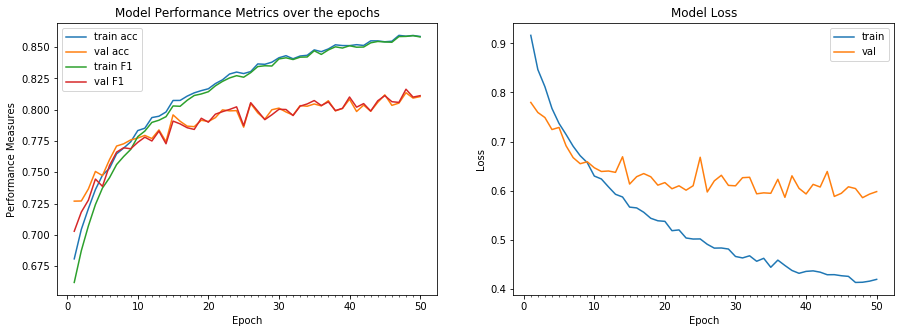

Model took 14.91 seconds to predict test set


In [112]:
# plot model history
plot_model_history(model_info)
# prep the held out dataset 
xHeldOut = np.rot90(np.reshape(holdOutRawFeatures, (10000,32,32,3), order='F'), axes=(2,1))
# compute accuracy on held out dataset
start = time.time()
y_predicted = CNN_Predict(model=model,test_x=xHeldOut)
print("Model took %0.2f seconds to predict test set"%(time.time() - start))

Accuracy of model is: 79.99
             precision    recall  f1-score   support

   airplane       0.80      0.84      0.82      1000
 automobile       0.91      0.92      0.91      1000
       bird       0.71      0.71      0.71      1000
        cat       0.68      0.56      0.61      1000
       deer       0.76      0.79      0.77      1000
        dog       0.82      0.65      0.72      1000
       frog       0.74      0.90      0.82      1000
      horse       0.83      0.85      0.84      1000
       ship       0.86      0.90      0.88      1000
      truck       0.88      0.88      0.88      1000

avg / total       0.80      0.80      0.80     10000



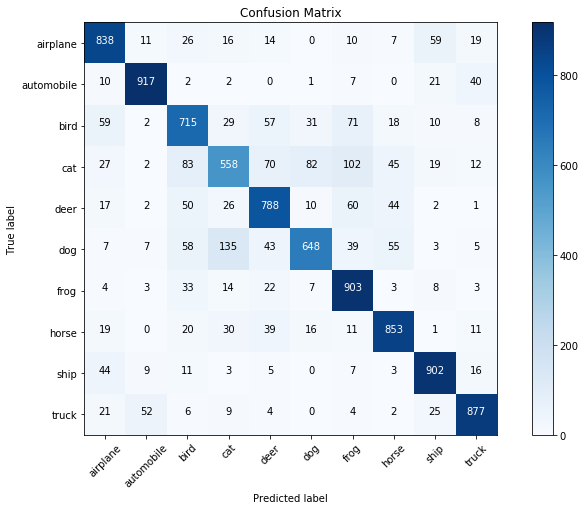

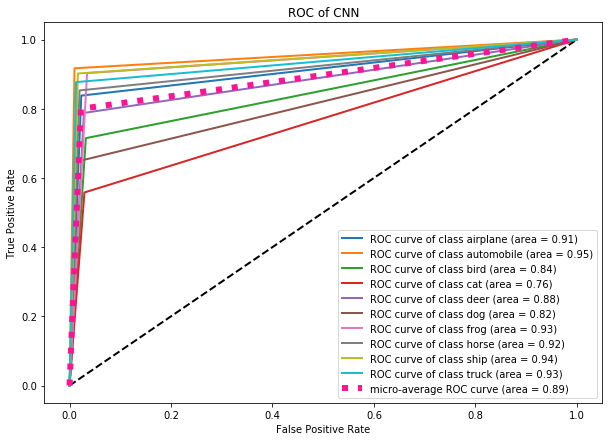

In [158]:
# evaluate the model 
EvaluateModel(y_pred=y_predicted, y_test=holdOutLabels)

In [176]:
# save the keras model (in HDF format)
_MODEL_NAME = "cifar10_v2"
model.save(_KERAS_BASE_PATH + _MODEL_NAME + ".h5")

with open(_KERAS_BASE_PATH + "/cifar10_v2_model_summary", 'wb') as fo:
    modelSummary = model_info.history
    pickle.dump(modelSummary, fo)

# returns a compiled model
# identical to the previous one
#from keras.models import load_model
#model2 = load_model('files/keras/cifar_v1.h5')
# Train the model
#start = time.time()
#print("Accuracy on test data is: %0.2f"%accuracy(xTest, y_test, model2))
#print("Model took %0.2f seconds to predict test set"%(time.time() - start))

In [165]:
print(labels)

[0 1 2 3 4 5 6 7 8 9]
<bound method Container.summary of <keras.models.Sequential object at 0x11c346be0>>


## BOVW - SVM

In [54]:
# helpers for image feature extraction and processing
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.color import rgb2gray
from skimage.exposure import equalize_hist
from skimage.filters import threshold_otsu
from skimage.feature import daisy
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

_codebook = None
_scaler = None


def show_images(images,titles=None):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure(figsize=(1.5,1.5))
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.gray() # Only place in this blog you can't replace 'gray' with 'grey'
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()
    
def ConvertToGray(RGBArray):
    grayImages = np.empty((RGBArray.shape[0],32,32))
    for i in range(RGBArray.shape[0]):
        # convert
        gray_image = rgb2gray(RGBArray[i,:,:,:])
        grayImages[i] = gray_image[np.newaxis,:,:]
    return grayImages

def extractDaisyFeatures(grayImages):
    #bov_descriptors = np.empty((grayImages.shape[0],49,152))
    bov_descriptors = np.empty((grayImages.shape[0],36,130))

    for i in range(grayImages.shape[0]):
        img = grayImages[i,:,:]
        descs = daisy(img, step=4, radius=5, rings=2, histograms=6, orientations=10, visualize=False)
        descsTransformed = descs.reshape((-1 ,descs.shape[2])) # flatten the features dimensions
        #print(descs.shape)
        #print(descsTransformed.shape)
        bov_descriptors[i] = descsTransformed

    return bov_descriptors

# generate the bag of visual words for classification
def GenerateBOVW(numClusters, descriptor_list, codebook):
    n_images = descriptor_list.shape[0]
    mega_histogram = np.array([np.zeros(numClusters) for i in range(n_images)])
    old_count = 0
    for i in range(n_images):
        l = len(descriptor_list[i])
        for j in range(l):
            idx = codebook[old_count+j]
            mega_histogram[i][idx] += 1
        old_count += l

    # standardise to offset bias
    scaler = StandardScaler().fit(mega_histogram)
    mega_histogram = scaler.transform(mega_histogram)
    
    return mega_histogram, scaler

def ConvertToBoVW(bwImages,kmeansModel,numWords=150): 
    
    # generate the daisy features
    descriptors = extractDaisyFeatures(bwImages)
    bov_descriptors = descriptors.reshape((-1, descriptors.shape[2]))

    codebook = kmeansModel.predict(bov_descriptors)
    
    # generate BoVW
    vocab = np.array([np.zeros(numWords) for i in range(bwImages.shape[0])])
    
    old_count = 0
    for i in range(bwImages.shape[0]):
        l = len(descriptors[i])
        for j in range(l):
            idx = codebook[old_count+j]
            vocab[i][idx] += 1
        old_count += l
    
    # scale using a saved scaler
    vocab = _scaler.transform(vocab)
    
    return vocab
    

In [49]:
# check the split dataset from before 

#y_train = y_train.argmax(axis=1)
#y_test = y_test.argmax(axis=1)

print(xTrain.shape)
print(y_train.shape)

print(xTest.shape)
print(y_test.shape)

print(y_train.dtype)


(40000, 32, 32, 3)
(40000,)
(10000, 32, 32, 3)
(10000,)
int64


Procesing took 1.81 seconds
shape of dataset after conversion to grayscale: (40000, 32, 32)


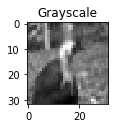

In [14]:
# prep the dataset for training and testing 
# convert the images to grayscale 
start = time.time()
grayImages = ConvertToGray(xTrain)
print("Procesing took %0.2f seconds"%(time.time() - start))

# visualise the transformation
print("shape of dataset after conversion to grayscale:", grayImages.shape)
gray_image = grayImages[1,:,:]
#equalized_image = equalize_hist(gray_image)
#thresh = threshold_otsu(gray_image)

show_images(images=[gray_image],
           titles=["Grayscale"])


In [15]:
# generate some SIFT features from the training set
#grayImages2d = grayImages.reshape((grayImages.shape[0], 1024)) # convert to 2d array if images
start = time.time()
descriptor_list = extractDaisyFeatures(grayImages)
print("Procesing took %0.2f seconds"%(time.time() - start))
print("shape of the keypoint descriptor set:", descriptor_list.shape)


Procesing took 93.66 seconds
shape of the keypoint descriptor set: (40000, 36, 130)


In [18]:
import sys

print(sys.getsizeof(descriptor_list)/1024/1024)
print(descriptor_list.shape)
# note to self - too large of a memory footprint - best to work with a loop instead.


1428.2227783203125
(40000, 36, 130)


Clustering range search took 162.05 seconds


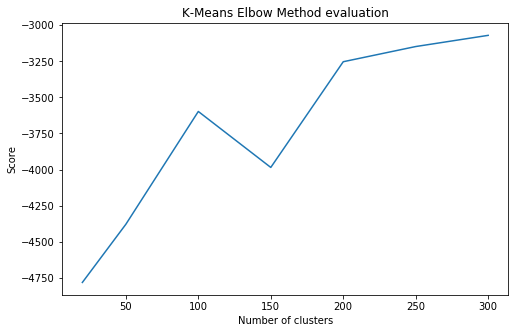

In [19]:
# carry out a k-means clustering 

# reshape to flatten the features dimensions
bov_descriptors = descriptor_list.reshape((-1, descriptor_list.shape[2]))

start = time.time()
range_n_clusters = [20,50,100,150,200,250,300]
km = [MiniBatchKMeans(n_clusters=i) for i in range_n_clusters]
score = [km[i].fit(bov_descriptors).score(bov_descriptors) for i in range(len(range_n_clusters))]
print("Clustering range search took %0.2f seconds"%(time.time() - start))

# plot to find the best K for the codebook for maximum explainability
plt.figure(figsize=(8,5))
plt.title("K-Means Elbow Method evaluation")
plt.plot(range_n_clusters, score)
plt.ylabel('Score')
plt.xlabel('Number of clusters')


In [55]:
# create bag of visual words 

# prep the best codebook
bestk = 200
visualWords = km[4].predict(bov_descriptors)
_codebook = km[4]

start = time.time()
BOVW, _scaler = GenerateBOVW(bestk, descriptor_list, visualWords)
print("Time taken to generate codebook: %0.2f seconds"%(time.time() - start))
print(BOVW.shape)


Time taken to generate codebook: 1.24 seconds
(40000, 200)


In [45]:
# convert the evaluation set for testing the classifier
_codebook = km[4]

start = time.time()
grayImages = ConvertToGray(xTest)
print(grayImages.shape)
testWords = ConvertToBoVW(grayImages,_codebook,numWords=bestk)
print("Feature extraction on test data took %0.2f seconds"%(time.time() - start))


SVM training took 447.21 seconds


SVM training took 754.24 seconds
Prediction operation took 91.21 seconds
SVM training took 506.60 seconds
Prediction operation took 86.80 seconds
SVM training took 439.31 seconds
Prediction operation took 83.73 seconds
SVM training took 461.03 seconds
Prediction operation took 84.92 seconds
SVM training took 483.68 seconds
Prediction operation took 85.78 seconds


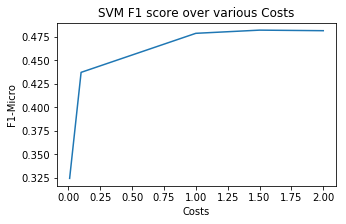

In [71]:
# train and test the model 

from sklearn.metrics import f1_score

Cs = [0.01, 0.1, 1, 1.5, 2]
f1s = list()

best_svm_clf = None
currentBest = 0.

for c in Cs:
    f1_current = 0.
    clf = SVC(C=c)
    start = time.time()
    clf.fit(BOVW, y_train)
    print("SVM training took %0.2f seconds"%(time.time() - start))
    start = time.time()
    preds = clf.predict(testWords)
    print("Prediction operation took %0.2f seconds"%(time.time() - start))
    
    f1_current = f1_score(y_test, preds, average='micro')
    if f1_current >= currentBest:
        currentBest = f1_current
        # save the model 
        best_svm_clf = clf
    f1s.append(f1_current)

plt.figure(figsize=(5,3))
plt.title("SVM F1 score over various Costs")
plt.plot(Cs, f1s)
plt.ylabel('F1-Micro')
plt.xlabel('Costs')


SVC(C=1.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


(10000, 32, 32, 3)
(10000,)
(10000, 32, 32)
Feature extraction on test data took 26.06 seconds
Prediction operation took 86.21 seconds
Accuracy of model is: 48.09
             precision    recall  f1-score   support

   airplane       0.55      0.53      0.54      1000
 automobile       0.50      0.59      0.54      1000
       bird       0.40      0.34      0.36      1000
        cat       0.32      0.30      0.31      1000
       deer       0.38      0.37      0.38      1000
        dog       0.45      0.48      0.46      1000
       frog       0.53      0.59      0.56      1000
      horse       0.56      0.49      0.52      1000
       ship       0.60      0.62      0.61      1000
      truck       0.49      0.51      0.50      1000

avg / total       0.48      0.48      0.48     10000



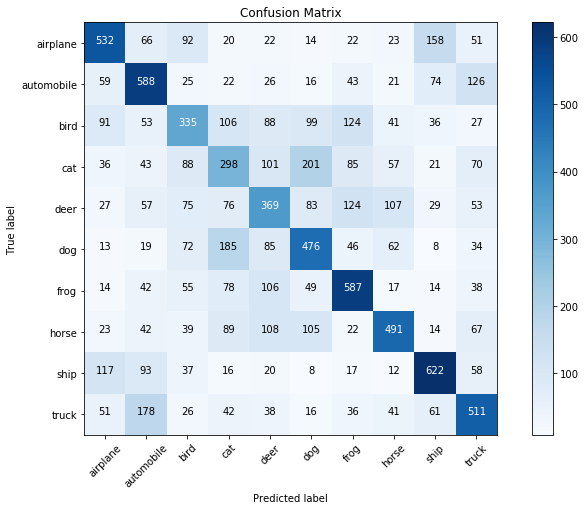

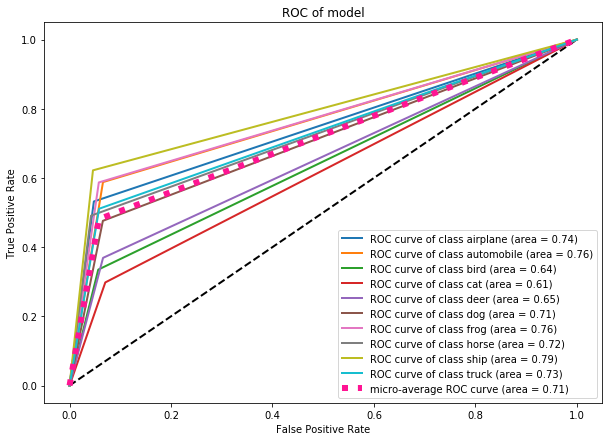

In [72]:
# test on the hold out dataset 

xHoldOut = np.rot90(np.reshape(holdOutRawFeatures, (10000,32,32,3), order='F'), axes=(2,1))
print(xHoldOut.shape)
print(holdOutLabels.shape)

# generate the words from the codebook
start = time.time()
grayImages = ConvertToGray(xHoldOut)
print(grayImages.shape)
holdOutWords = ConvertToBoVW(grayImages,_codebook,numWords=bestk)
print("Feature extraction on test data took %0.2f seconds"%(time.time() - start))

# predict using the best svm classifier
start = time.time()
preds = best_svm_clf.predict(holdOutWords)
print("Prediction operation took %0.2f seconds"%(time.time() - start))

# evaluatate the model
EvaluateModel(y_pred=preds, y_test=holdOutLabels)


In [30]:
# try an adaboost classifier and compare performances 

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf_ada = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=50),
    n_estimators=600,
    learning_rate=1)
start = time.time()
clf_ada.fit(train_data, train_labels)
print("Adaboosted training took %0.2f seconds"%(time.time() - start))
preds = clf_ada.predict(eval_data)


Adaboosted training took 1644.74 seconds


Accuracy of model is: 36.82
             precision    recall  f1-score   support

   airplane       0.38      0.43      0.40       973
 automobile       0.33      0.40      0.36       979
       bird       0.28      0.13      0.18      1030
        cat       0.29      0.22      0.25      1023
       deer       0.30      0.31      0.31       933
        dog       0.36      0.45      0.40      1015
       frog       0.43      0.60      0.50       996
      horse       0.37      0.28      0.32       994
       ship       0.40      0.51      0.45      1017
      truck       0.46      0.36      0.40      1040

avg / total       0.36      0.37      0.36     10000



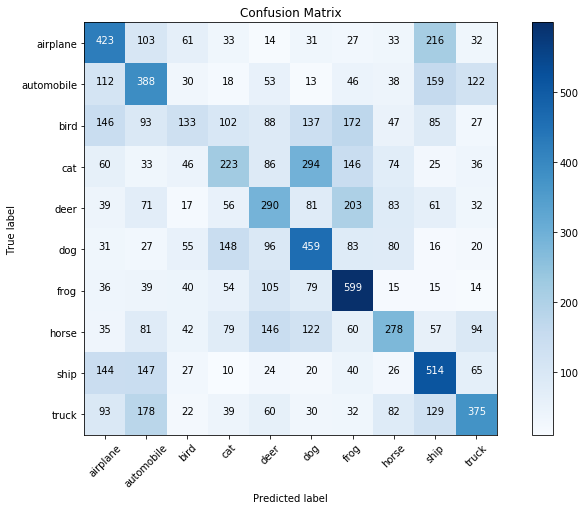

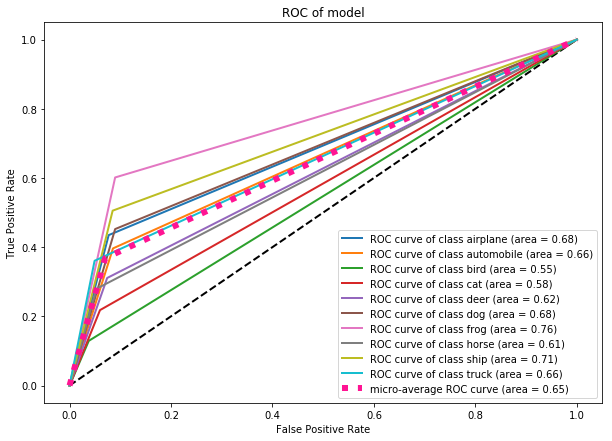

In [34]:
# evaluatate the adaboost model
EvaluateModel(y_pred=preds, y_test=eval_labels)


(3240,)


/Users/nagibshah/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


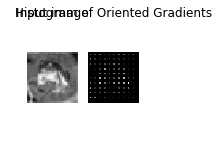

(3240,)


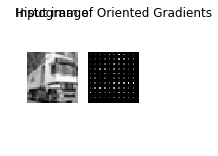

(3240,)


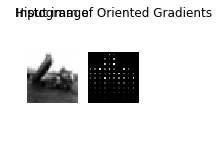

(3240,)


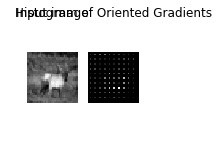

(3240,)


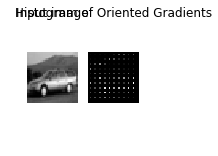

In [88]:
from skimage.feature import hog
from skimage import exposure

def extractHogFeatures(image):
    
    fd,hog_image = hog(image, pixels_per_cell=(3, 3), cells_per_block=(2, 2),visualise=True,orientations=10,
                       
             feature_vector=True)
    return fd, hog_image

for i in range(5):
    image = grayImages[i,:,:]
    tmp, hog_image = extractHogFeatures(image)
    print(tmp.shape)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2, 2), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(image, cmap=plt.cm.gray)
    ax1.set_title('Input image')

    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    ax2.axis('off')
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    plt.show()
    

In [265]:
from sklearn import decomposition

pca = decomposition.PCA()
start = time.time()
# Plot the PCA spectrum
pca.fit(grayImages2d)
print("Procesing took %0.2f seconds"%(time.time() - start))



Procesing took 8.55 seconds


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

SVC = SVC()

#SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
#    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
#    max_iter=-1, probability=False, random_state=None, shrinking=True,
#    tol=0.001, verbose=False)

pipe = Pipeline(steps=[('pca', pca), ('SVC', SVM)])

# Prediction
n_components = [10,50,150,200,500]
Cs = [0.01, 0.1, 1, 1.5]
kernels = ["rbf"]

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,dict(pca__n_components=n_components,SVC__C=Cs))

start = time.time()
estimator.fit(grayImages2d, yTrain)
print("GridsearchCV took %0.2f seconds"%(time.time() - start))


In [1]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

NameError: name 'plt' is not defined